# Store Sales Forecasting
### Time Series (ARIMA)

This notebook explores the <b>Autoregressive Integrated Moving Average (ARIMA)</b> approach for predicting product sales. The focus is on applying and understanding this model using a dataset obtained for this purpose.
This model includes the essential components for a time series model.

<b>Model Workflow For Sales Forecasting:</b><br>
<b>1.</b> Importing Essential Libraries.<br>
<b>2.</b> Initial Data Loading & Preprocessing.<br>
<b>3.</b> Extracting Time Components from Dates for Enhanced Data Analysis & Data Splitting.<br>
<b>4.</b> Defining, Fitting, & Summarizing the SARIMA Model for Sales Forecasting.<br>
<b>5.</b> Generating Sales Forecasts & Calculating Prediction Errors.<br>
<b>6.</b> Assessing SARIMA Model Performance with Key Forecasting Metrics.<br>
<b>7.</b> Visualizing Sales Forecast Accuracy with ARIMA Model Predictions.<br>
<b>8.</b> Summarizing Overall Sales Performance: Comparing Actual vs. Predicted Totals.<br>

<b>Dataset:</b><br>
<b>1.</b> Data Transformation.<br>
<b>2.</b> Dividing The Dataset Into Multiple Files.<br>

<b>This Notbook Has Been Structured As The Following:</b><br>
Forecasting The First Item <b>=></b> Model Workflow With Explanation For Each Step <b>=></b> Starting With The Second Item Through The Sixth Item <b>=></b> Finally All The Items Combined.

________________________________________________________________________________________________________________________________
# Forecast For The First Item:
<b>1. Importing Essential Libraries for Sales Forecasting and Data Visualization:</b><br>

- importing essential Python libraries specifically tailored for ARIMA (AutoRegressive Integrated Moving Average) and SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) models in sales forecasting, along with libraries for data manipulation and visualization.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import median_absolute_error, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

<b>2. Initial Data Loading and Preprocessing for Store Sales Analysis:</b><br>

- The primary actions taken:<br> 
  <b>1- </b> loading the sales data from a CSV file<br>
  <b>2- </b> conducting initial preprocessing steps:<br>
  <b>I- </b> filtering the data for a specific store.<br>
  <b>II- </b> converting date strings to datetime objects.<br>
  <b>III- </b> Setting 'date' as an index this lead for more straightforward                   slicing, and time-based grouping of the data.

In [2]:
df = pd.read_csv('C:/Users/moham/Desktop/storeItemsMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)

<b>3. Extracting Time Components from Dates for Enhanced Data Analysis & Data Splitting:</b><br>

- The process of breaking down the date column into more granular time components like:<br>
  <b>I- </b> year<br>
  <b>II- </b> month<br>
  <b>III- </b> day<br>
  <b>IV- </b> weekday<br>
  <b>V- </b>Preparing the dataset for the subsequent modeling process by                   splitting it into training and testing sets, a key stepin                       evaluating the model's performance on unseen data.
  is a key step in preparing and enriching the dataset for detailed time series   analysis.

In [3]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]

<b>4. Defining, Fitting, and Summarizing the SARIMA Model for Sales Forecasting:</b>

- setting up the SARIMA model with specific parameters, fitting it to the         training data, and then displaying a summary of the model to understand its     characteristics and performance indicators.

In [4]:
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -661.161
Date:                           Wed, 13 Dec 2023   AIC                           1328.323
Time:                                   16:47:32   BIC                           1335.888
Sample:                                        0   HQIC                          1331.376
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5046      0.109     -4.638      0.000      -0.718      -0.291
ar.S.L7       -0.4826      0.082     -5.883

<b>5. Generating Sales Forecasts and Calculating Prediction Errors:</b>

- generating future sales predictions using the SARIMA model for the test         dataset, aligning the predicted values with the actual data, and then           calculating the differences (errors) between the predicted and actual sales     figures.

In [5]:
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']

<b>6. Assessing SARIMA Model Performance with Key Forecasting Metrics:</b>

- calculating and displaying important statistical metrics to evaluate the       performance of the SARIMA model in forecasting sales, including measures of     error magnitude and model accuracy.<br>
<b>I. MAE (Mean Absolute Error):</b> Average of absolute errors, provides a straightforward measure of forecast accuracy, less sensitive to outliers.<br>
<b>II. RMSE (Root Mean Squared Error):</b> Square root of the average squared errors, emphasizes larger errors, more sensitive to outliers.<br>
<b>III. R² (R-squared):</b> Indicates how well model predictions approximate actual values, higher values mean better fit.<br>
<b>IV. Adjusted R²:</b> R² adjusted for the number of predictors, more reliable for models with multiple predictors.<br>
<b>V. Accuracy (R² as Percentage):</b> R² expressed in percentage, giving an intuitive view of model performance.<br>

- These metrics together give a comprehensive view of the model's accuracy,       error magnitude, and overall fit, crucial for assessing the effectiveness of   your SARIMA model in sales forecasting.

In [6]:
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

,Metric,Value
0,MAE,199.276120
1,RMSE,238.081304
2,R2,-0.007450
3,Adjusted R2,-0.070415
4,Accuracy,-0.744979


<b>7. Visualizing Sales Forecast Accuracy with ARIMA Model Predictions:</b>

- highlighting the comparison of actual sales to the ARIMA model's forecasts     and the visual representation of the forecast accuracy.

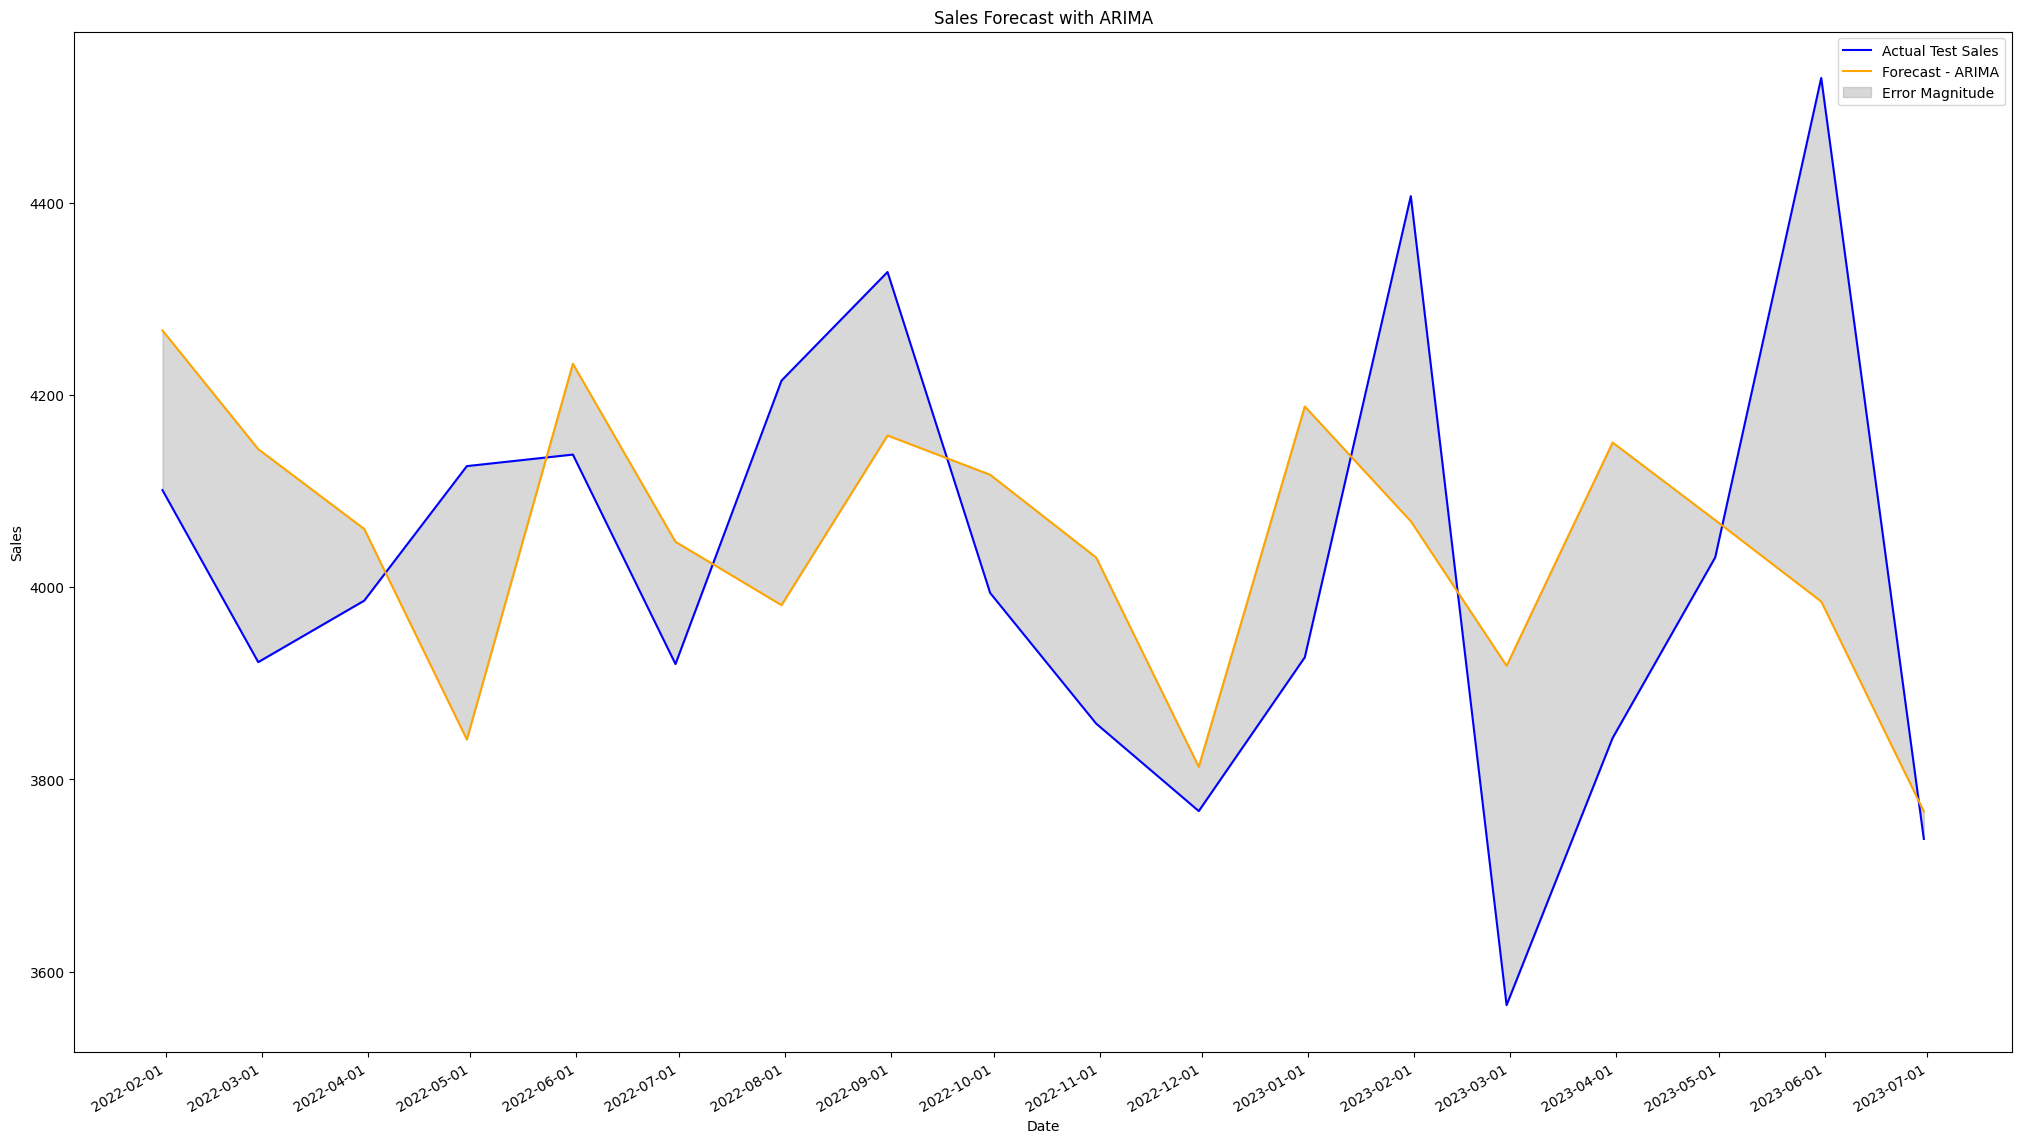

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

<b>8. Summarizing Overall Sales Performance: Comparing Actual vs. Predicted Totals:</b>

- calculating and displaying the total actual and predicted sales, providing a   high-level comparison of the model's forecasting results against real-world     data.

In [8]:
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))


Total Actual Sales: 72396.00
Total Predicted Sales: 72839.62


________________________________________________________________________________________________________________________________
# Forecast For The Second Item:
- The same previous steps will be repated.

In [9]:
df = pd.read_csv('C:/Users/moham/Desktop/itemTwoMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -521.183
Date:                           Wed, 13 Dec 2023   AIC                           1048.366
Time:                                   16:47:43   BIC                           1055.931
Sample:                                        0   HQIC                          1051.419
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3998      0.107     -3.725      0.000      -0.610      -0.189
ar.S.L7       -0.5841      0.097     -6.000

,Metric,Value
0,MAE,90.358858
1,RMSE,105.572899
2,R2,-2.611172
3,Adjusted R2,-2.836870
4,Accuracy,-261.117194


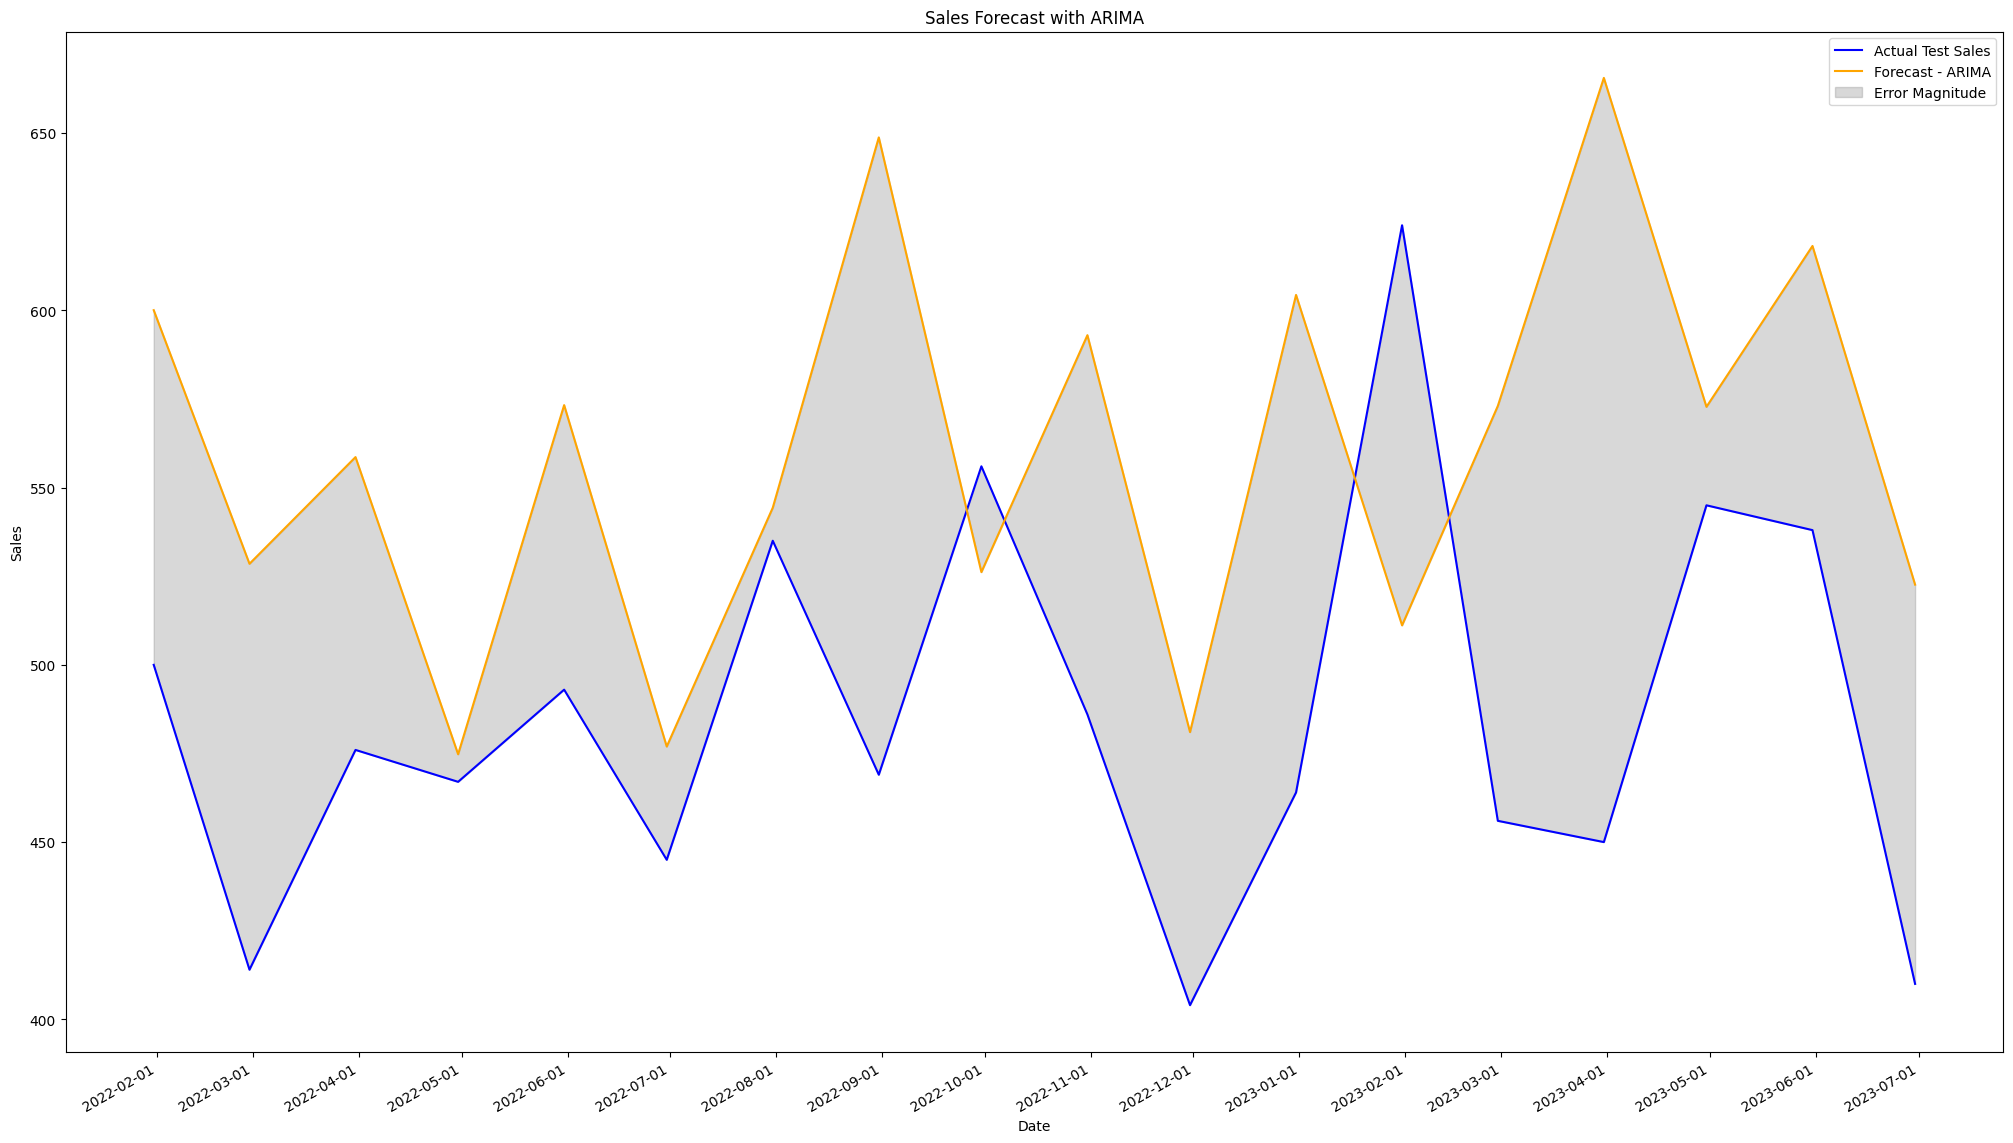


Total Actual Sales: 8732.00
Total Predicted Sales: 10073.03


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))

________________________________________________________________________________________________________________________________
# Forecast For The Third Item:
- The same previous steps will be repated.

In [11]:
df = pd.read_csv('C:/Users/moham/Desktop/itemThreeMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -563.287
Date:                           Wed, 13 Dec 2023   AIC                           1132.574
Time:                                   16:47:47   BIC                           1140.140
Sample:                                        0   HQIC                          1135.628
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4789      0.097     -4.937      0.000      -0.669      -0.289
ar.S.L7       -0.3335      0.104     -3.195

,Metric,Value
0,MAE,256.259453
1,RMSE,273.183768
2,R2,-44.165629
3,Adjusted R2,-46.988481
4,Accuracy,-4416.562875


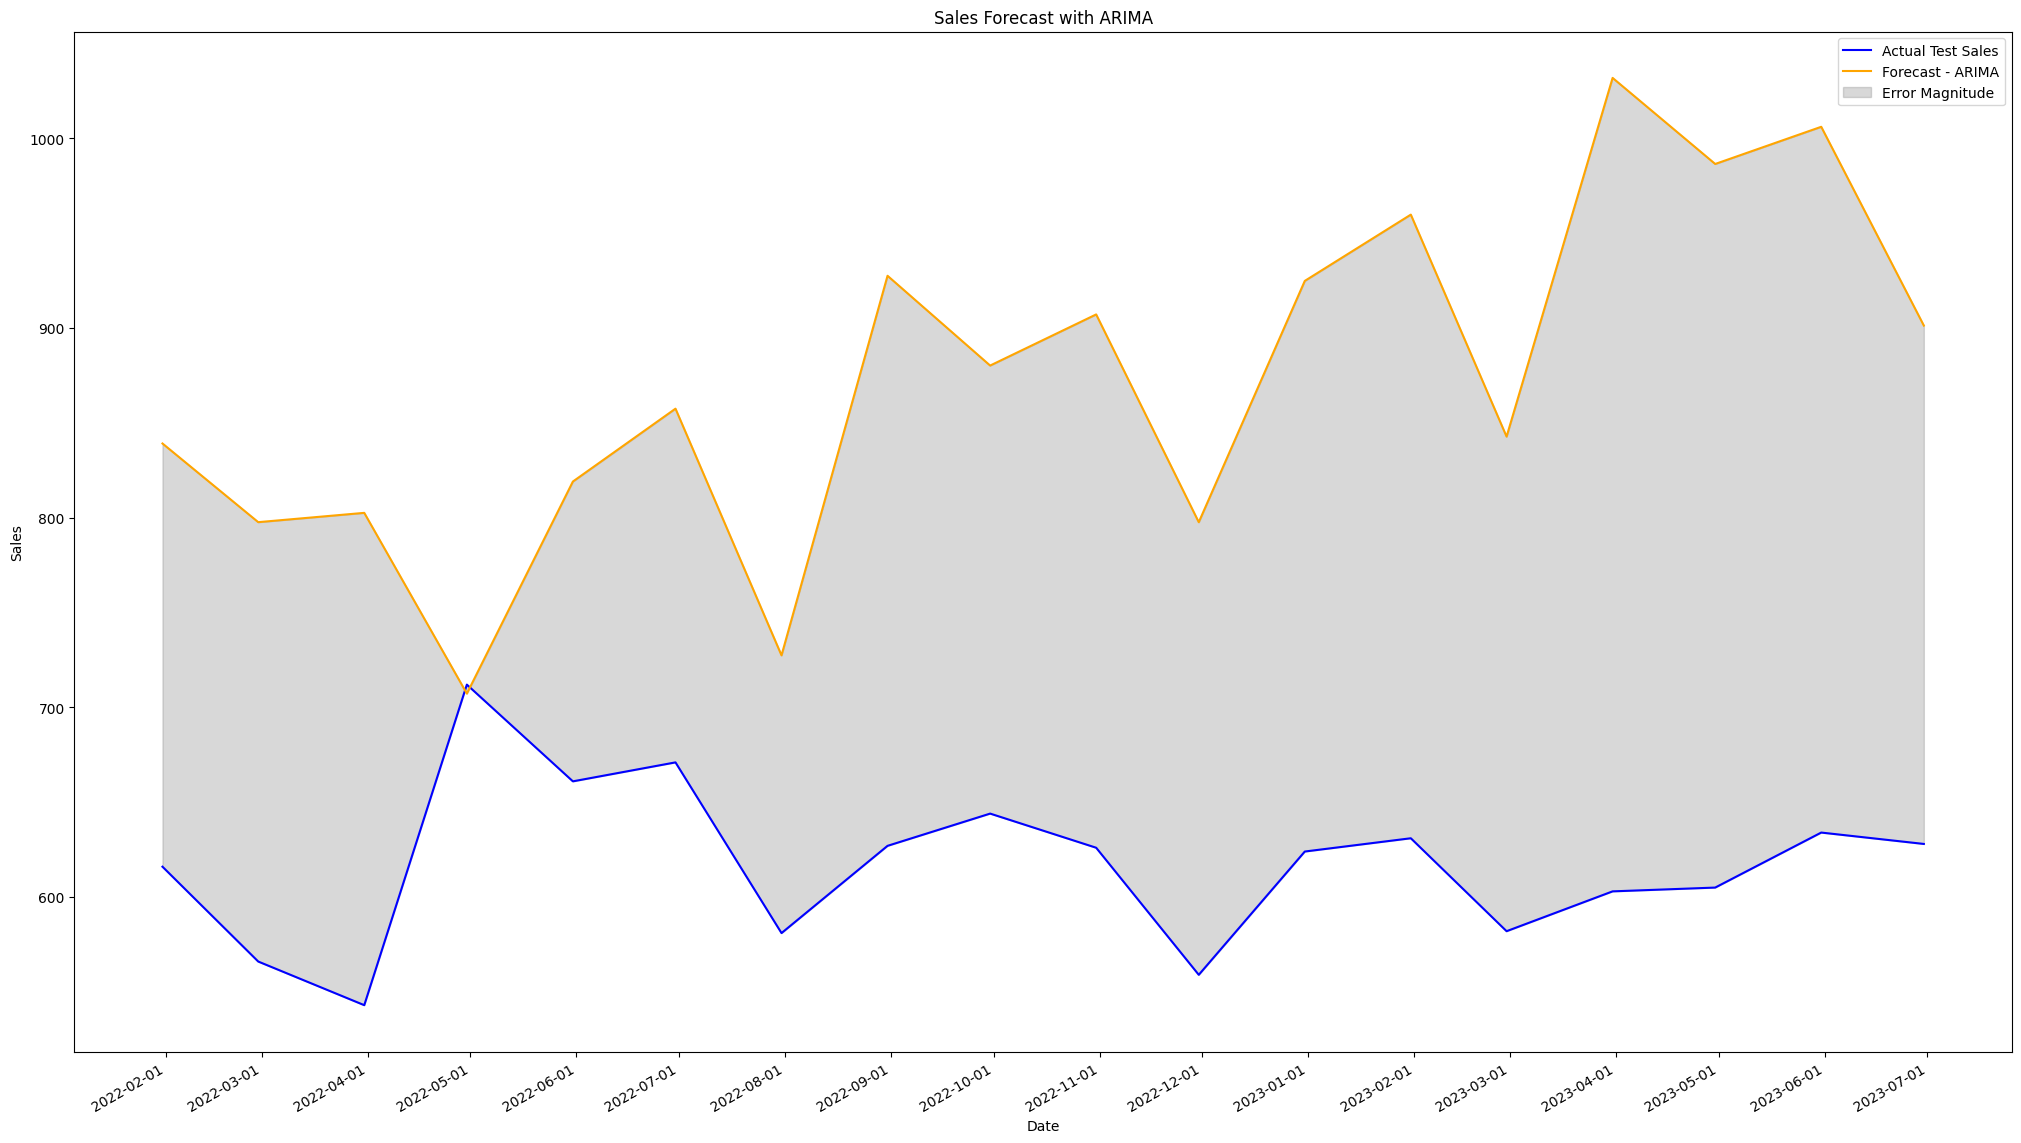


Total Actual Sales: 11113.00
Total Predicted Sales: 15716.18


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))

________________________________________________________________________________________________________________________________
# Forecast For The Fourth Item:
- The same previous steps will be repated.

In [13]:
df = pd.read_csv('C:/Users/moham/Desktop/itemFourMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -565.987
Date:                           Wed, 13 Dec 2023   AIC                           1137.974
Time:                                   16:47:59   BIC                           1145.540
Sample:                                        0   HQIC                          1141.028
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5039      0.085     -5.953      0.000      -0.670      -0.338
ar.S.L7       -0.5158      0.089     -5.822

,Metric,Value
0,MAE,82.377125
1,RMSE,103.972722
2,R2,-0.857886
3,Adjusted R2,-0.974004
4,Accuracy,-85.788589


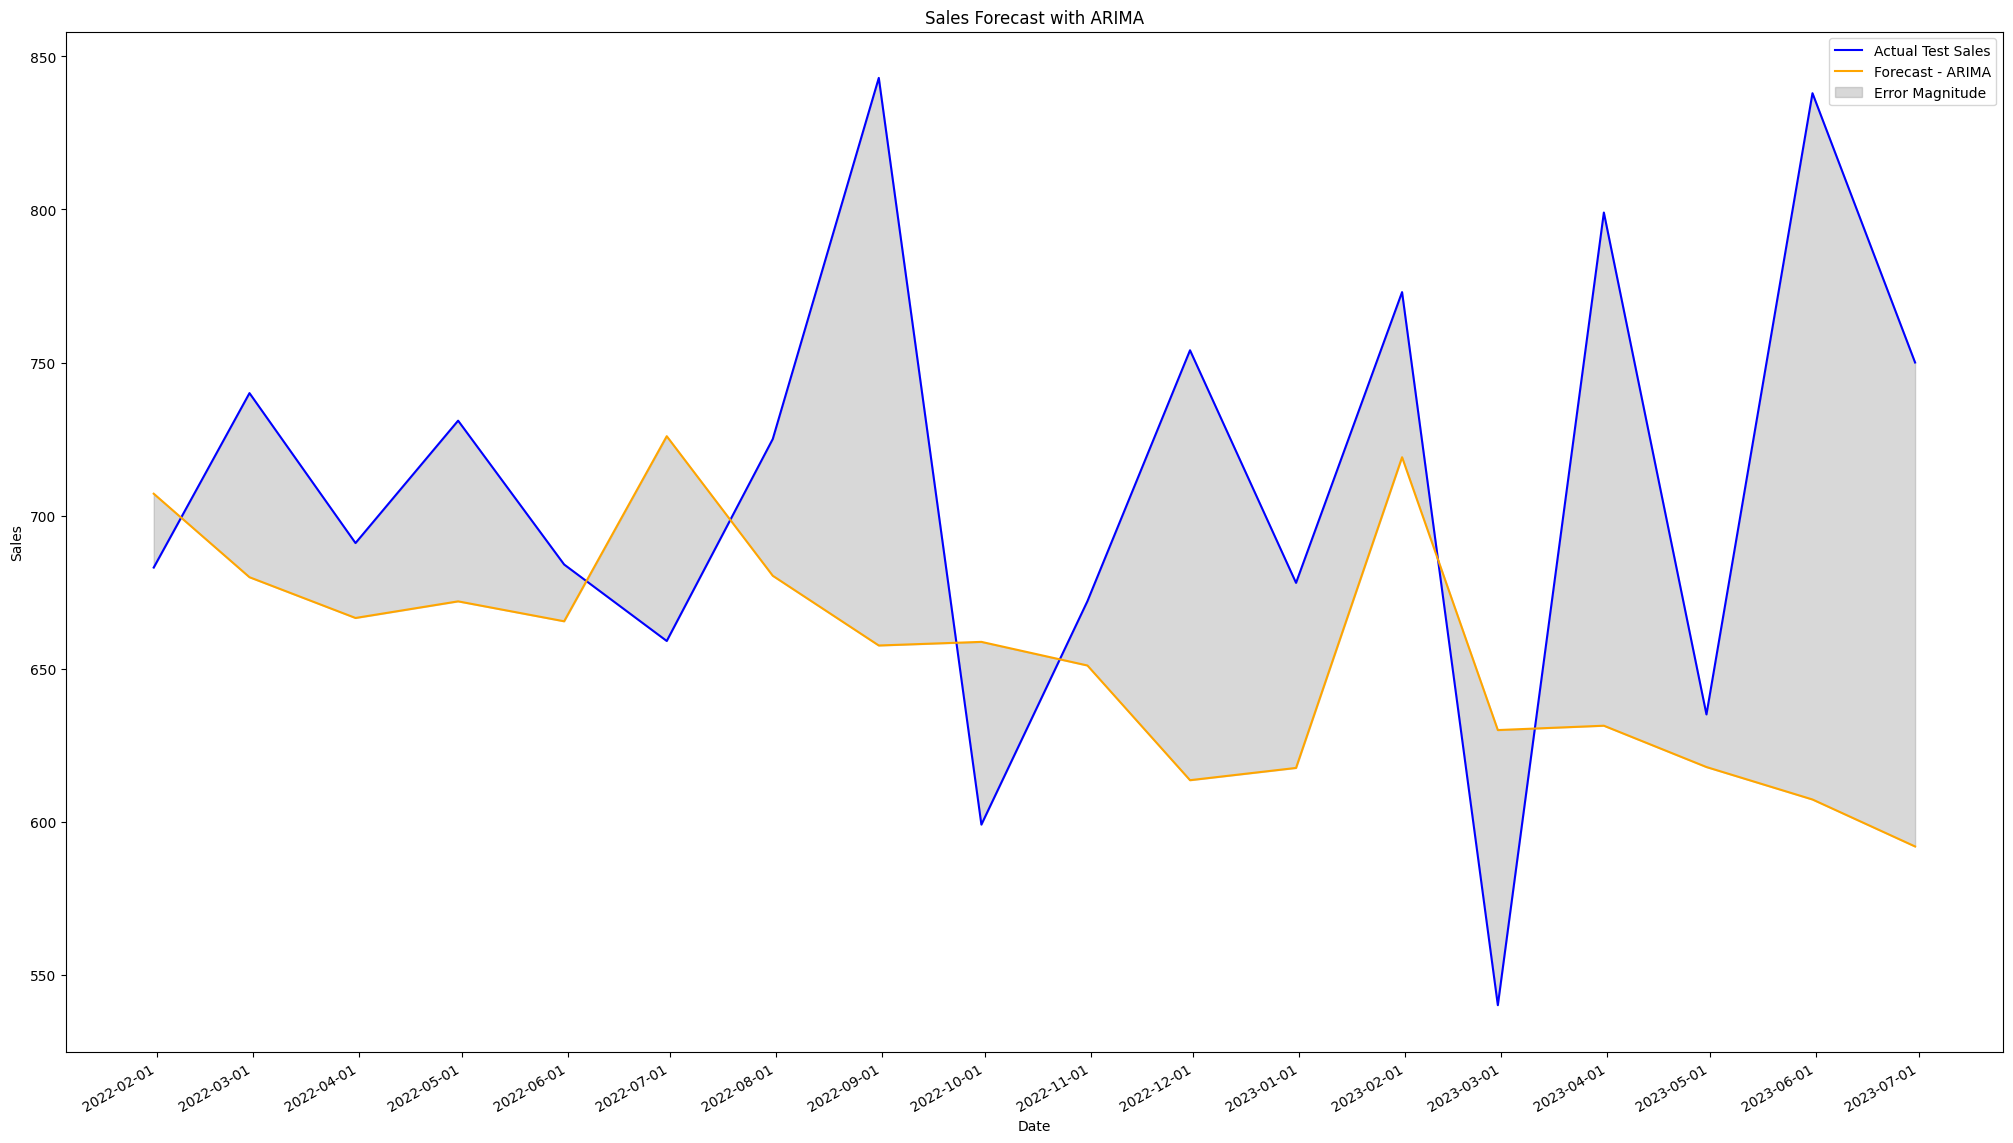


Total Actual Sales: 12794.00
Total Predicted Sales: 11792.53


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))

________________________________________________________________________________________________________________________________
# Forecast For The Fifth Item:
- The same previous steps will be repated.

In [15]:
df = pd.read_csv('C:/Users/moham/Desktop/itemFiveMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -583.308
Date:                           Wed, 13 Dec 2023   AIC                           1172.616
Time:                                   16:48:05   BIC                           1180.181
Sample:                                        0   HQIC                          1175.670
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5318      0.100     -5.318      0.000      -0.728      -0.336
ar.S.L7       -0.5380      0.082     -6.598

,Metric,Value
0,MAE,195.621399
1,RMSE,215.012054
2,R2,-6.043082
3,Adjusted R2,-6.483275
4,Accuracy,-604.308225


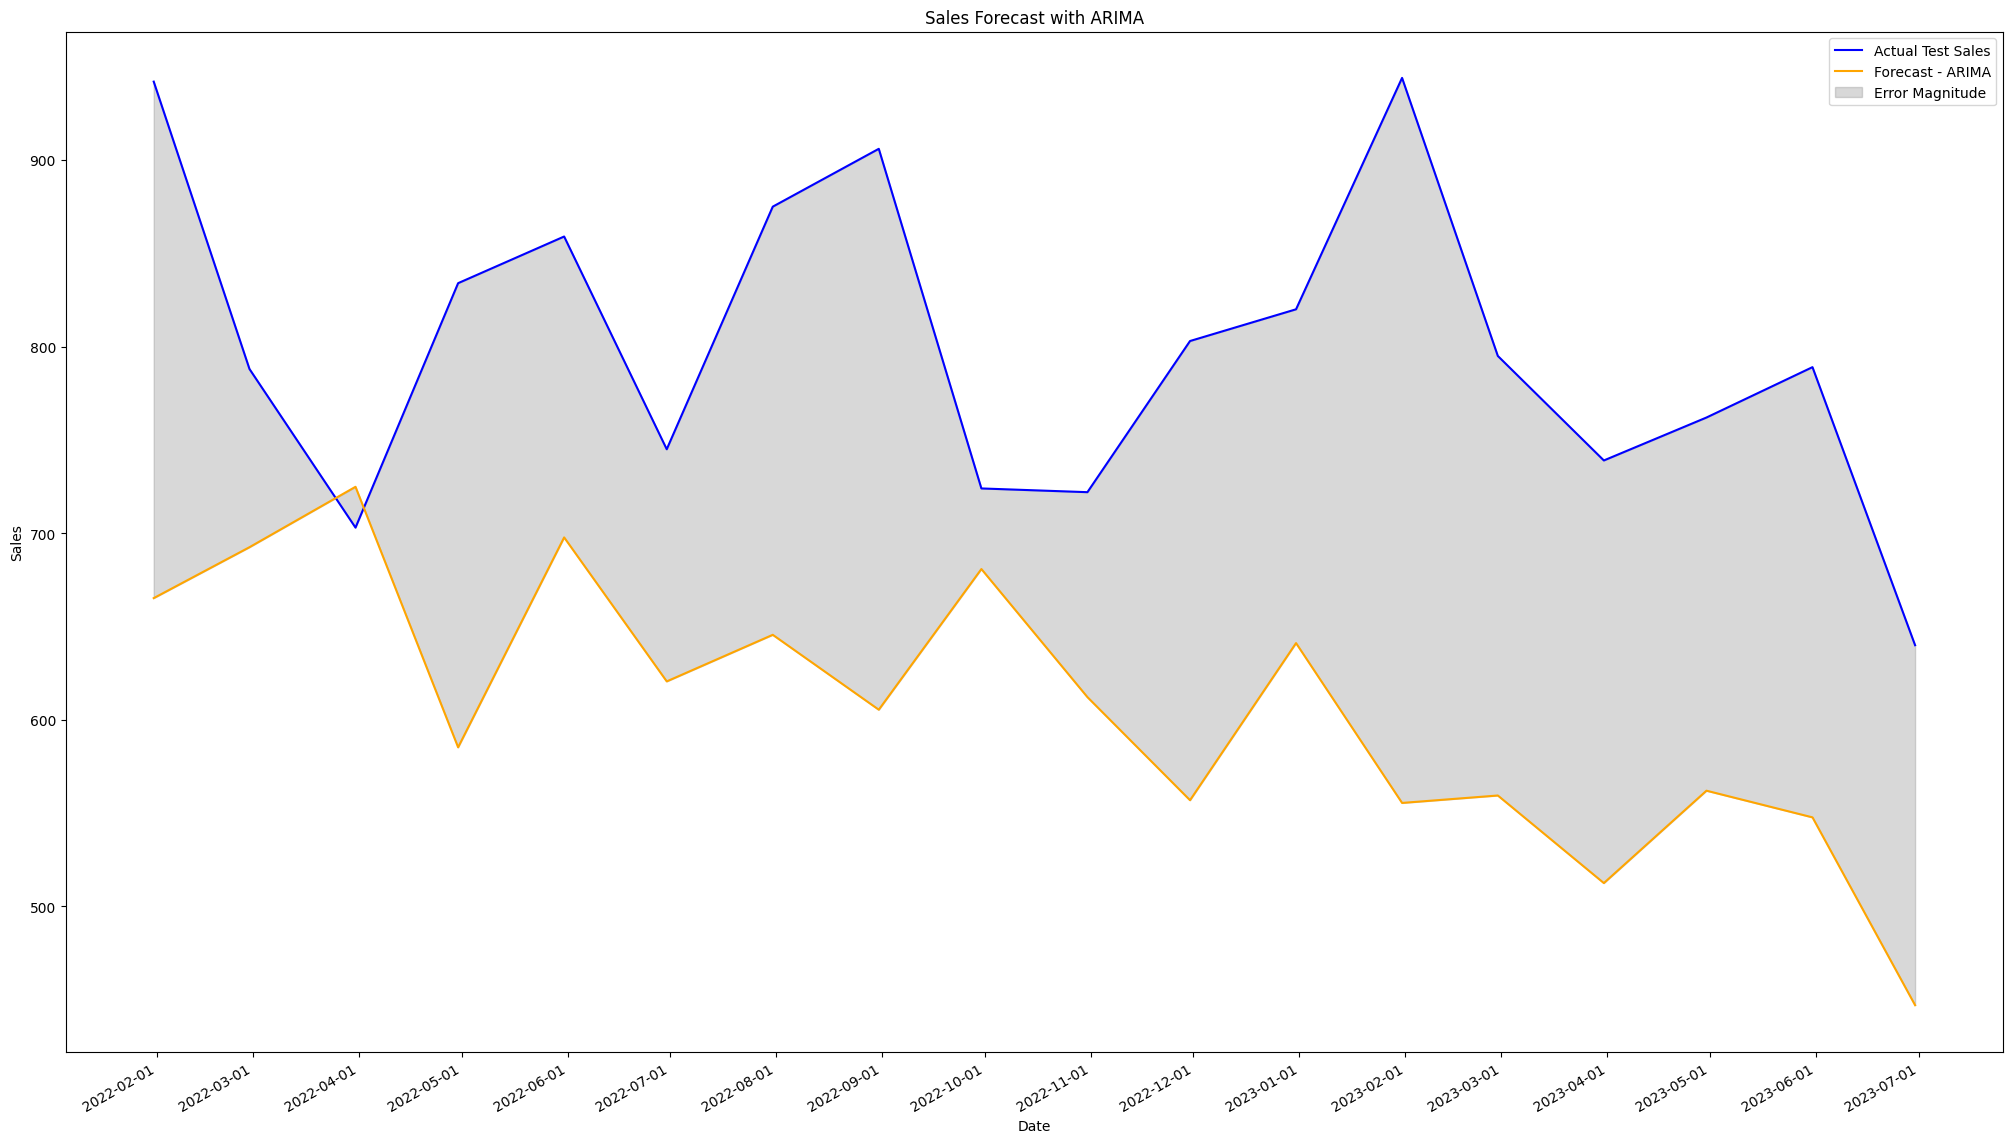


Total Actual Sales: 14390.00
Total Predicted Sales: 10912.58


In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))

________________________________________________________________________________________________________________________________
# Forecast For The Sixth Item:
- The same previous steps will be repated.

In [17]:
df = pd.read_csv('C:/Users/moham/Desktop/itemSixMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -582.994
Date:                           Wed, 13 Dec 2023   AIC                           1171.988
Time:                                   16:48:11   BIC                           1179.554
Sample:                                        0   HQIC                          1175.042
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4512      0.103     -4.399      0.000      -0.652      -0.250
ar.S.L7       -0.5441      0.088     -6.188

,Metric,Value
0,MAE,138.701079
1,RMSE,156.423073
2,R2,-1.303974
3,Adjusted R2,-1.447973
4,Accuracy,-130.397422


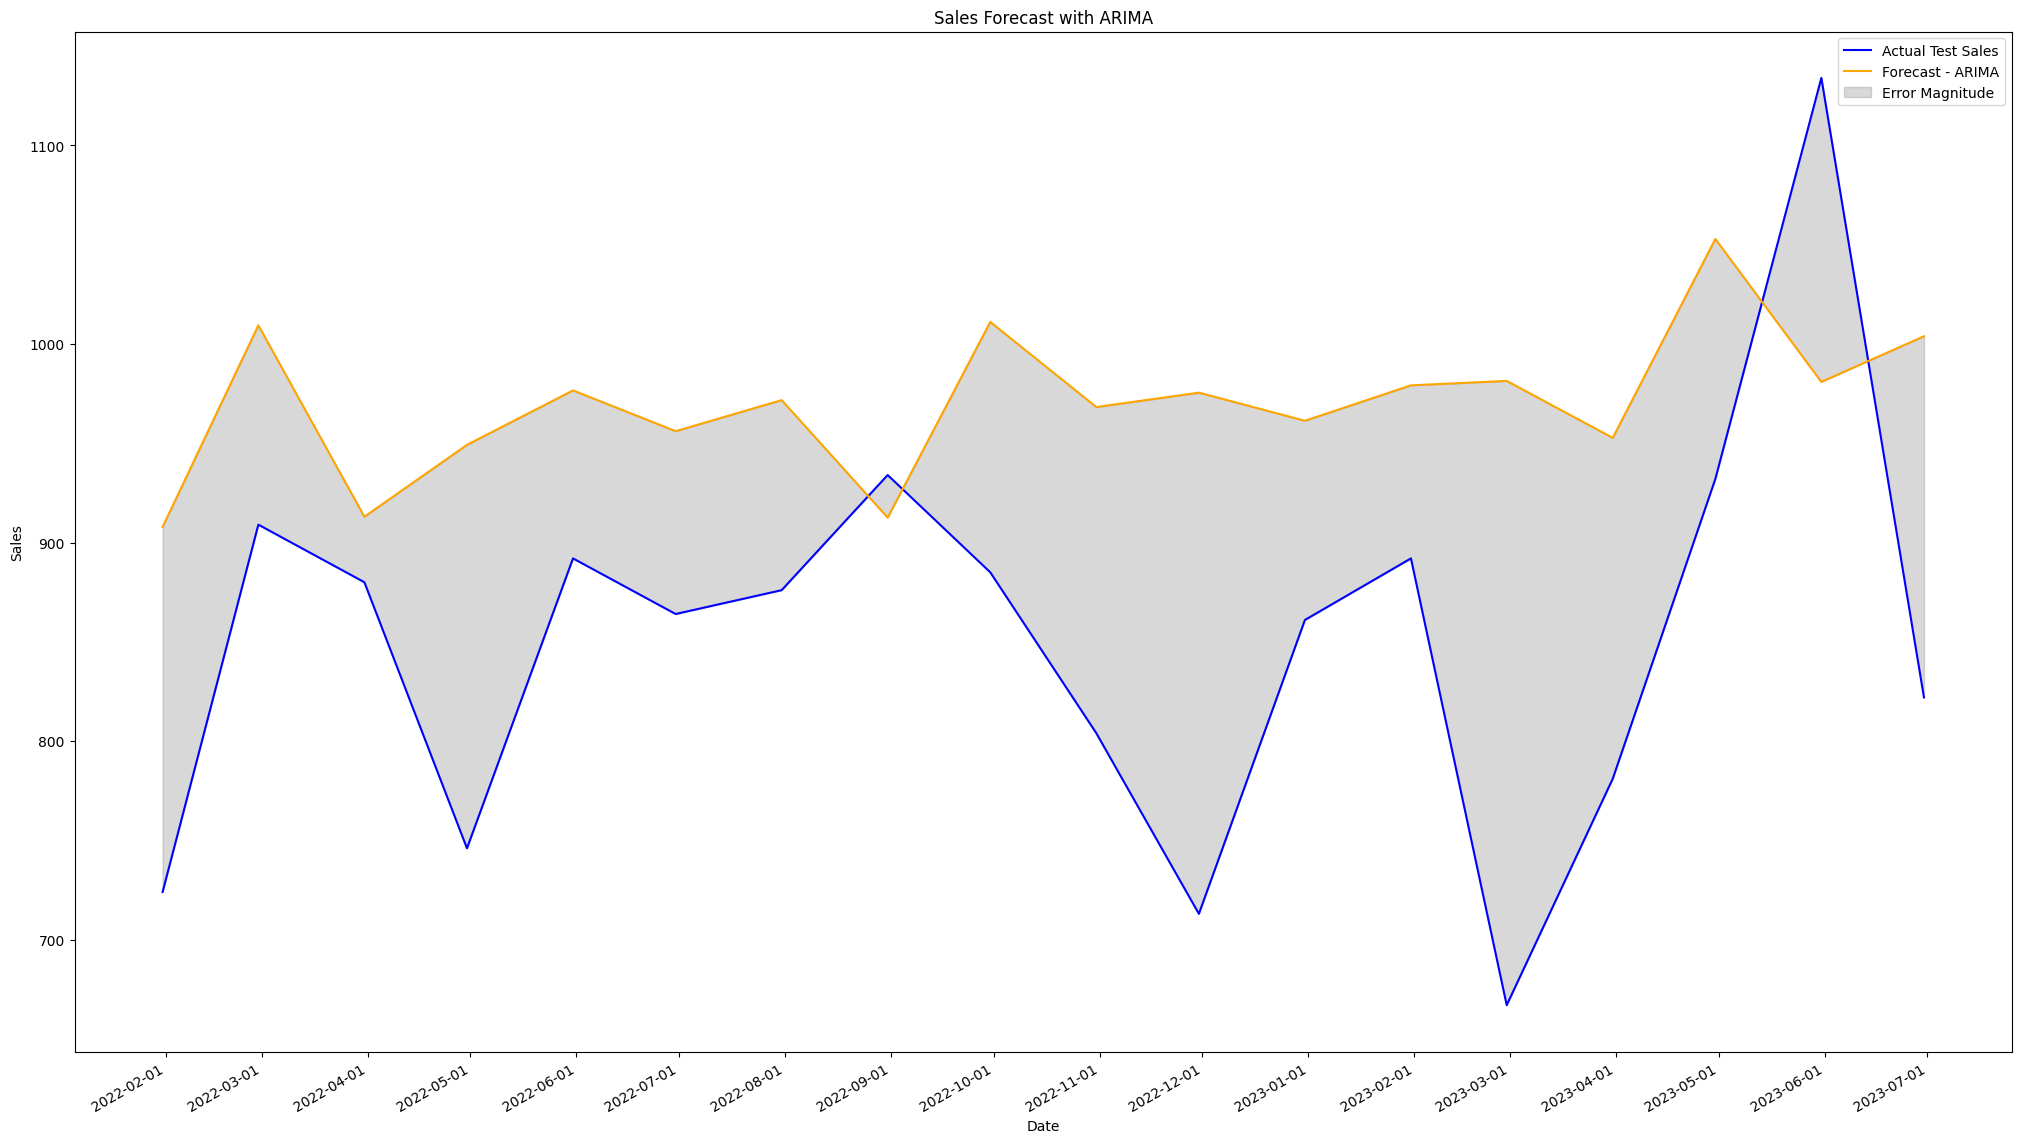


Total Actual Sales: 15316.00
Total Predicted Sales: 17463.49


In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))

________________________________________________________________________________________________________________________________
# Forecast For All The Store Items:
- The same previous steps will be repated.

In [19]:
df = pd.read_csv('C:/Users/moham/Desktop/storeItemsMS.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df.set_index('date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])
train_df = df.loc[:'2021-12-31']
test_df = df.loc['2022-01-01':]
sarima_model = SARIMAX(train_df['sales'], 
                       order=(1, 1, 0), 
                       seasonal_order=(1, 1, 0, 7),
                       enforce_invertibility=False, 
                       enforce_stationarity=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())
forecast_horizon = len(test_df)
pred_sales = sarima_fit.get_forecast(steps=forecast_horizon).predicted_mean
pred_sales.index = test_df.index
test_df['pred_sales'] = pred_sales
test_df['errors'] = test_df['sales'] - test_df['pred_sales']
def adjusted_r2(r_squared, n, k): 
    return 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
n = test_df.shape[0]
k = 1  
mae = np.mean(np.abs(test_df['errors']))
rmse = sqrt(mean_squared_error(test_df['sales'], test_df['pred_sales']))
r2 = r2_score(test_df['sales'], test_df['pred_sales'])
adj_r2 = adjusted_r2(r2, n, k)
accuracy = r2 * 100  
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R2', 'Adjusted R2', 'Accuracy'],
    'Value': [mae, rmse, r2, adj_r2, accuracy]
})
metrics_df

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -661.161
Date:                           Wed, 13 Dec 2023   AIC                           1328.323
Time:                                   16:48:16   BIC                           1335.888
Sample:                                        0   HQIC                          1331.376
                                           - 108                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5046      0.109     -4.638      0.000      -0.718      -0.291
ar.S.L7       -0.4826      0.082     -5.883

,Metric,Value
0,MAE,199.276120
1,RMSE,238.081304
2,R2,-0.007450
3,Adjusted R2,-0.070415
4,Accuracy,-0.744979


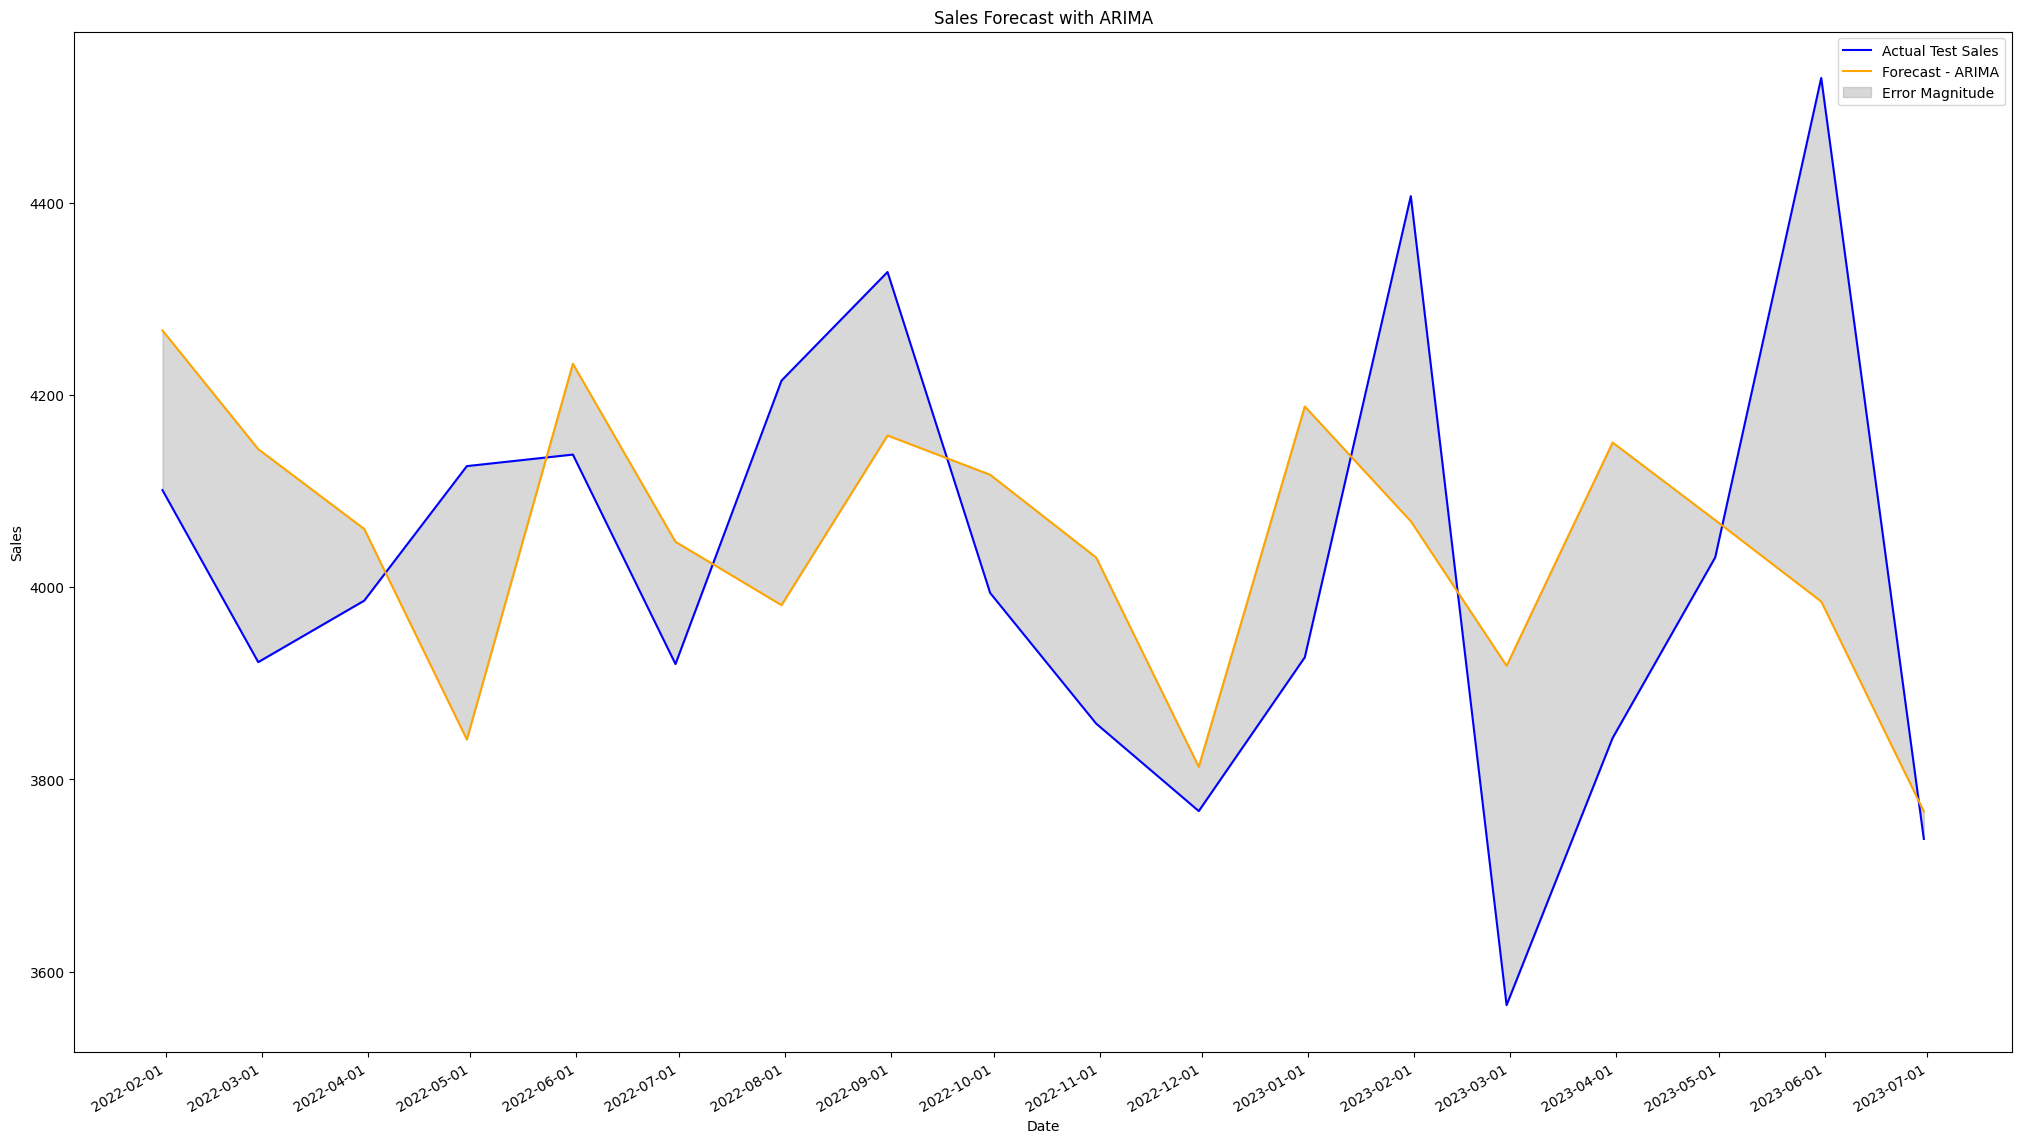


Total Actual Sales: 72396.00
Total Predicted Sales: 72839.62


In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(25, 15))
plt.plot(test_df.index, test_df['sales'], label='Actual Test Sales', color='blue')
plt.plot(test_df.index, test_df['pred_sales'], label='Forecast - ARIMA', color='orange')
plt.fill_between(test_df.index, test_df['sales'], test_df['pred_sales'], color='gray', alpha=0.3, label='Error Magnitude')
plt.title('Sales Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()
total_actual_sales = test_df['sales'].sum()
total_predicted_sales = test_df['pred_sales'].sum()
print("\nTotal Actual Sales: {:.2f}".format(total_actual_sales))
print("Total Predicted Sales: {:.2f}".format(total_predicted_sales))